# Project : Walmart Sales in Stormy Weather
---

# 1. Data Introduce
### 1.1 Purpose : Predict how sales of weather-sensitive products are affected by snow and rain
    

### 1.2 Data set:
   > - Train Data : 4617600 rows, 4 columns

   > - Test Data  : 526917 rows, 3 columns

   > - Weather Data : 20517 rows, 20 columns
   
   > - Key Data : 45 rows, 2 columns
   
   > - [링크 : Walmart Recruiting II: Sales in Stormy Weather](https://www.kaggle.com/c/walmart-recruiting-sales-in-stormy-weather)

### 1.3 Evaluation
   > - Root Mean Squared Logarithmic Error (RMSLE)  

$$
RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
$$


In [1]:
# Import libraries
'''
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
'''
from scipy import stats
from statsmodels.graphics import utils

# Import the functions used in this project
import my_functions as mf 

from datetime import datetime

# Pretty display for notebooks
'''
%matplotlib inline
'''

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
train = pd.read_csv("../asset/train.csv")
test = pd.read_csv("../asset/test.csv")
weather = pd.read_csv("../asset/weather.csv")
key = pd.read_csv("../asset/key.csv")
submission = pd.read_csv("../asset/sampleSubmission.csv")

# Success - Display the first record
print("Train data : ", train.shape)
print("Test  data : ", test.shape)
print("weather  data : ", weather.shape)
print("key  data : ", key.shape)
print("submission  data : ", submission.shape)

# 원본을 유지하기 위해서 카피
df_train = train.copy()
df_test = test.copy()
df_weather = weather.copy()
df_key = key.copy()
df_submission = submission.copy()

Train data :  (4617600, 4)
Test  data :  (526917, 3)
weather  data :  (20517, 20)
key  data :  (45, 2)
submission  data :  (526917, 2)


# 2. Exploring the Data

## Train data의 모습을 살펴보자

In [2]:
print("Train data : ", df_train.shape)
print("Test  data : ", df_test.shape)

Train data :  (4617600, 4)
Test  data :  (526917, 3)


In [3]:
df_train.tail()

,date,store_nbr,item_nbr,units
4617595,2014-10-31,45,107,0
4617596,2014-10-31,45,108,0
4617597,2014-10-31,45,109,0
4617598,2014-10-31,45,110,0
4617599,2014-10-31,45,111,0


In [4]:
df_train.head(1)

,date,store_nbr,item_nbr,units
0,2012-01-01,1,1,0


In [5]:
df_train.tail(1)

,date,store_nbr,item_nbr,units
4617599,2014-10-31,45,111,0


## 2012-01-01일부터 2014-10-31일 까지 총 1035일간의 데이터이다.

In [6]:
df_test.tail()

,date,store_nbr,item_nbr
526912,2014-10-26,45,107
526913,2014-10-26,45,108
526914,2014-10-26,45,109
526915,2014-10-26,45,110
526916,2014-10-26,45,111


## train 데이터의 컬럼을 살펴보면 units 컬럼 외 에는 통계값을 계산하는 것이 의미가없다.

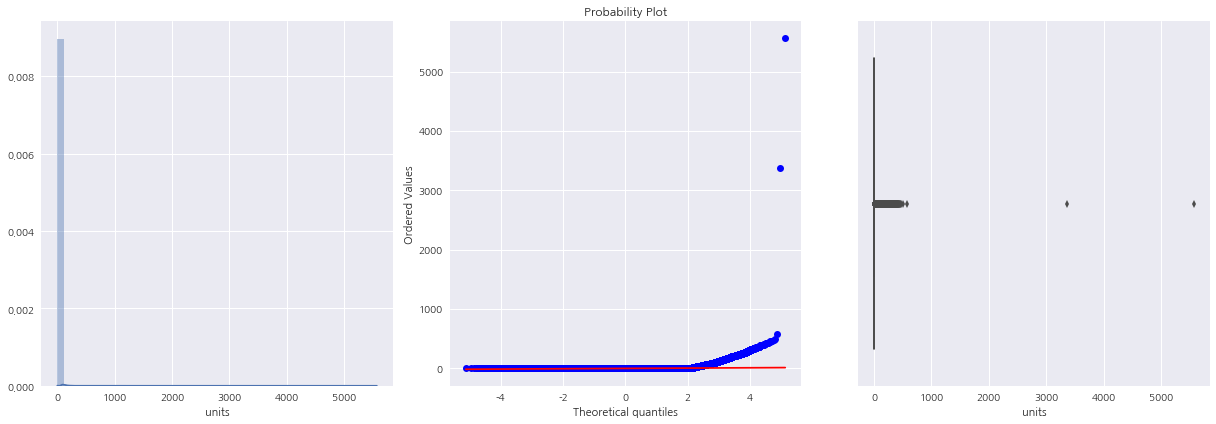

In [7]:
plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(df_train["units"])

plt.subplot(132)
stats.probplot(df_train["units"], plot=plt)

plt.subplot(133)
sns.boxplot(df_train["units"])
plt.tight_layout()
plt.show()

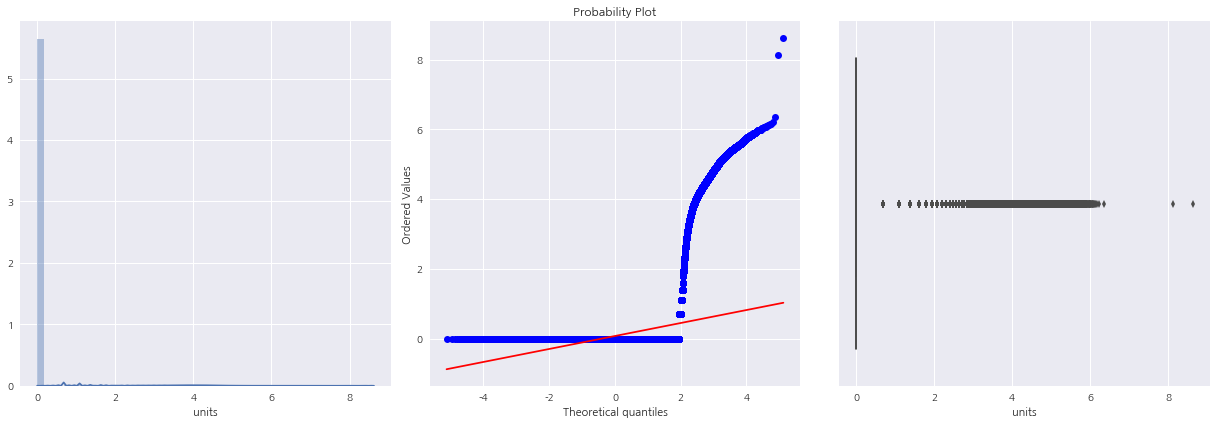

In [8]:
train_units_log1p = np.log1p(df_train["units"])

plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(train_units_log1p)

plt.subplot(132)
stats.probplot(train_units_log1p, plot=plt)

plt.subplot(133)
sns.boxplot(train_units_log1p)
plt.tight_layout()
plt.show()

In [9]:
df_train["units"].describe()

count    4.617600e+06
mean     9.868756e-01
std      9.875798e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.568000e+03
Name: units, dtype: float64

## units컬럼의 평균값은 0.986이다. 

# 2-2 Feature Type

## Weather 데이터가 우리에게 주어진 Feature Matrix이다.

In [10]:
df_weather.shape

(20517, 20)

In [11]:
df_weather.head()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,,0.0,0.00,29.95,30.47,14.0,36,13.8


In [12]:
sorted(df_weather["station_nbr"].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

## 총 20개의 기상청의 데이터이다. 

## Numerical, Categorical Features 나누어서 확인해보자.

In [13]:
weather_data_cp = df_weather.copy()
weather_data_cp = mf.changeTypes(weather_data_cp)
numerical_features, categorical_features = mf.divideIntoNumericAndCategoricalVariables(weather_data_cp)

Numerical Features Qty : 17 

Numerical Features :  ['tmax', 'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed'] 


Categorical Features Qty : 2 

Categorical Features : ['station_nbr', 'codesum']


## Walmart로부터 제공받은 weather 관련 document에 따르면 M, T, - Data가 포함되어있다.

Variables with Missing Qty :  [17]
Total Missing values Qty :  [51752]


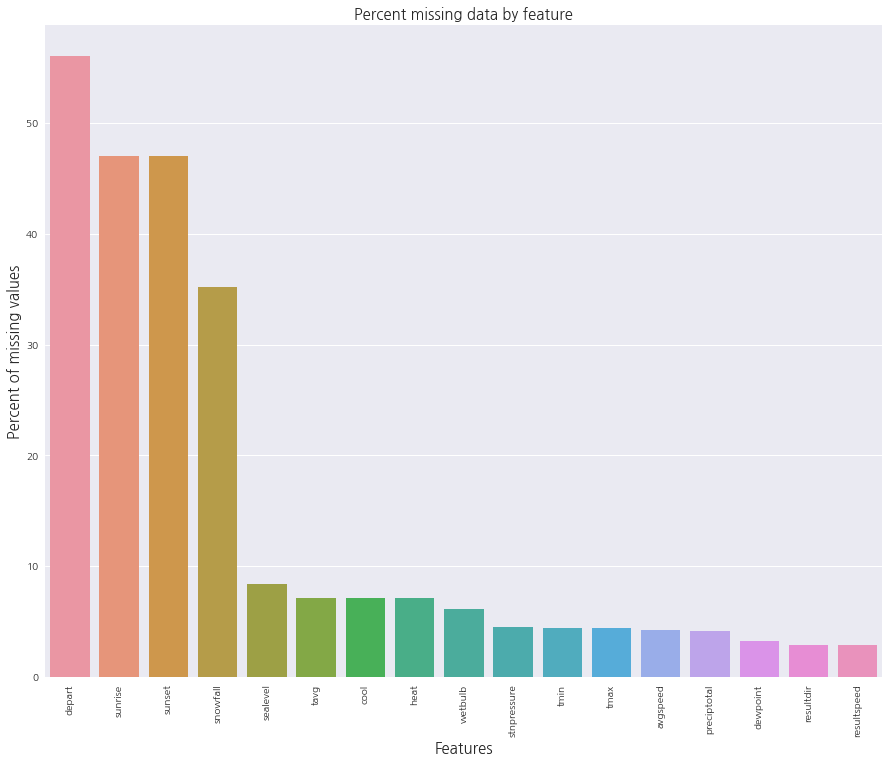

In [14]:
# Chck missing values 
weather_data_null = weather_data_cp.isnull().sum()
weather_data_null = weather_data_null.drop(weather_data_null[weather_data_null == 0].index).sort_values(ascending=False)
weather_data_missing = pd.DataFrame({'Missing Numbers' :weather_data_null})
weather_data_null =  weather_data_null / len(weather_data_cp)*100

# Barplot missing values
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=weather_data_null.index, y=weather_data_null)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

print("Variables with Missing Qty : " , weather_data_missing.count().values)
print("Total Missing values Qty : " , weather_data_missing.sum().values)

## 전체적으로 Depart, Sunrise, Sunset, Snowfall은 Missing Value가 많이 포함되어있다.

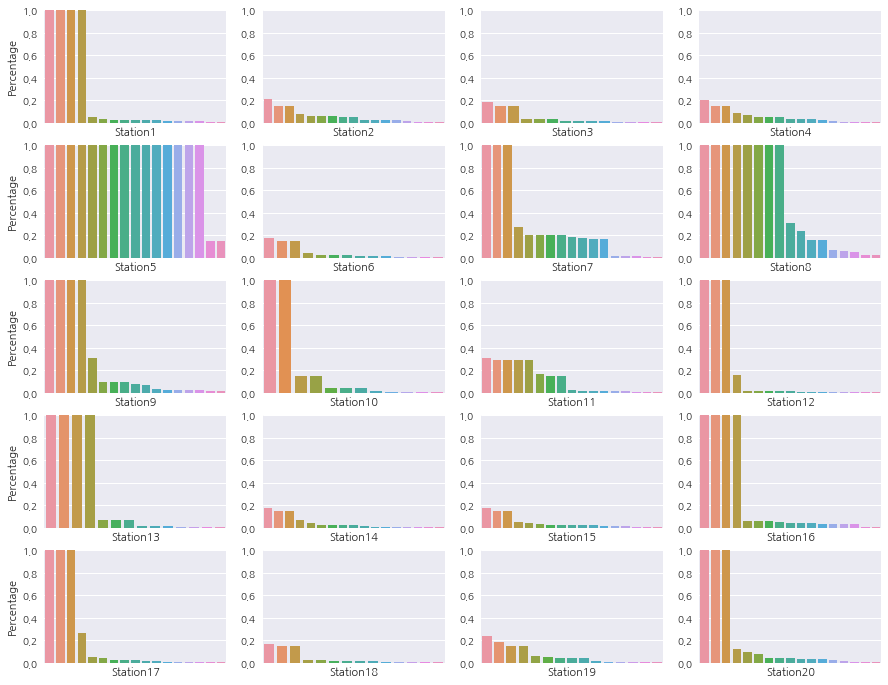

In [15]:
f, ax = plt.subplots(5, 4, figsize=(15, 12))

for idx, station in enumerate(sorted(weather_data_cp["station_nbr"].unique())):
    df = weather_data_cp.copy()
    station_weather = df[df["station_nbr"] == station]
    # Chck missing values 
    weather_data_null = station_weather.isnull().sum()
    weather_data_null = weather_data_null.drop(weather_data_null[weather_data_null == 0].index).sort_values(ascending=False)
    weather_data_missing = pd.DataFrame({'Missing Numbers' :weather_data_null})
    weather_data_null =  weather_data_null / len(weather_data_cp)*100
    # Barplot missing values
    sns.barplot(x=weather_data_null.index, y=weather_data_null\
               , ax = ax[idx//4, idx%4])
    ax[idx//4, 0].set_ylabel("Percentage")
    ax[idx//4, idx % 4].set_ylim(0, 1)
    ax[idx//4, idx % 4].set_xticks([])
    ax[idx//4, idx % 4].set_xlabel("Station" + str(station))

## 1. Station 별로 Missing 데이터 개수가 다르다. 5번은 특히 거의 Missing value로 이루어져있다.

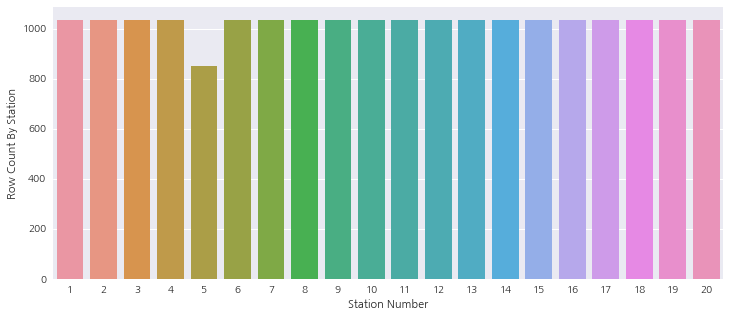

In [16]:
plt.figure(figsize=(12, 5))
sns.barplot(sorted(df_weather["station_nbr"].unique()), list(df_weather.groupby("station_nbr").size()))
plt.ylabel("Row Count By Station")
plt.xlabel("Station Number")
plt.show()

## 2. 5번 스테이션만 전체 데이터가 부족하다(2012-01-01 부터 2014-10-31까지가 아니다).

In [17]:
mf.classifyStoresByStation(df_key).sort_values(by = "station_nbr").reset_index(drop=True)

,station_nbr,store_nbr
0,1,1
1,2,16
2,3,"21, 29, 33"
3,4,8
4,5,35
5,6,"7, 13"
6,7,"3, 20, 28"
7,8,39
8,9,"4, 24"
9,10,"11, 22, 27"


# 3. Feature Engineering

## 3-1 Missing Values Processing

### 3-1-1 Train

In [18]:
df_unit_sales = df_train.pivot_table(["units"], ["store_nbr"], ["item_nbr"], aggfunc=np.sum)
df_unit_sales

units                                                        ...   \
item_nbr    1     2    3    4      5      6    7      8       9    10  ...    
store_nbr                                                              ...    
1             0     0    0    0      0      0    0      0   27396    0 ...    
2             0     0    0    0  55104      0    0      0       0    0 ...    
3             0  1083    0    0  56663      0    0      0       0    0 ...    
4             0     0    0    0      0      0    0      0  117123    0 ...    
5             0     0    0    0      0      0    0      0       0    0 ...    
6             0     0    0    0      0      0    0      0   50431    0 ...    
7             0     0    0    0  62230      0  721      0       0    0 ...    
8             0     0    0    0  32647      0    0      0       0    0 ...    
9             0     0    0    0  45024      0    0      0       0  745 ...    
10            0     0    0    0  61866      0    0      0       0    0 ...    
11            0     0    0    0      0      0    0      0   34103    0 ...    
12            0     0    0    0      0      0    0      0       0    0 ...    
13            0     0    0    0  67241      0    0      0       0    0 ...    
14            0     0    0    0      0      0    0      0   12164    0 ...    
15            0     0    0    0  64522      0    0      0       0    0 ...    
16            0     0    0    0      0      0    0      0       0    0 ...    
17            0     0    0    0      0      0    0      0  135367    0 ...    
18            0     0    0    0  16565      0    0      0       0    0 ...    
19            0     0    0    0      0      0    0      0       0    0 ...    
20            0     0    0    0  71034      0    0      0       0    0 ...    
21            0     0    0    0  41641      0    0      0       0    0 ...    
22            0     0    0    0      0      0    0      0   42880    0 ...    
23            0     0    0    0  28810      0    0      0       0    0 ...    
24            0     0    0    0      0  41398    0      0       0    0 ...    
25            0     0    0    0      0      0    0      0   98560    0 ...    
26            0  1482    0    0  43448      0    0      0       0    0 ...    
27            0     0    0    0      0      0    0      0   31652    0 ...    
28            0   704    0    0  33338      0    0      0       0    0 ...    
29            0     0    0    0      0      0    0  30345       0    0 ...    
30            0     0    0    0      0      0    0      0       0    0 ...    
31            0     0    0    0      0      0    0      0   48233    0 ...    
32            0     0    0    0      0      0    0      0   41888    0 ...    
33            0     0    0    0      0      0    0      0  101586    0 ...    
34            0     0    0    0      0      0    0      0   51789    0 ...    
35            0     0    0    0      0      0    0      0       0    0 ...    
36          778     0    0    0      0      0    0      0   35874    0 ...    
37            0     0    0    0  50063      0    0      0       0    0 ...    
38            0     0    0    0      0      0    0      0   66679    0 ...    
39            0     0    0    0      0      0    0      0    5057    0 ...    
40            0     0    0    0  48454      0    0      0       0    0 ...    
41            0     0    0    0      0      0    0      0       0    0 ...    
42            0     0    0    0  35178      0    0      0       0    0 ...    
43            0     0  675    0      0      0    0      0       0    0 ...    
44            0     0    0    0  32834      0    0      0       0    0 ...    
45            0     0    0  348      0      0    0      0   15833    0 ...    

                                                              
item_nbr  102  103  104  105 106  107   108   109   110  111  
store_nbr                                                     
1           0    0    0    0

## 모든 상점에서 같은 종류의 아이템들을 파는 것이 아니다.

In [19]:
item_nbrs, store_nbrs = mf.report_item_sales(df_train)

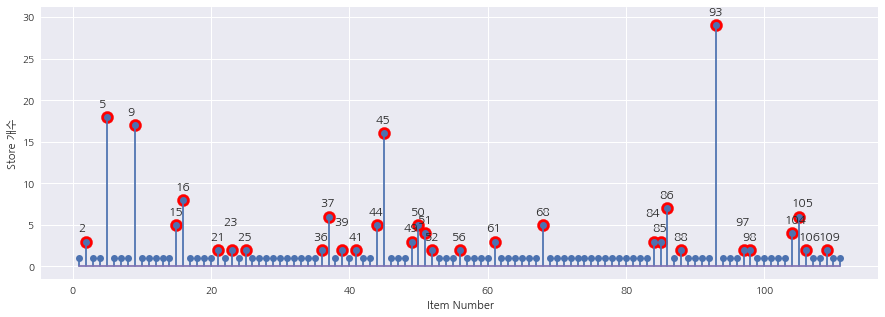

In [20]:
plt.figure(figsize=(15, 5))
item_nbrs = np.array(item_nbrs)
store_nbrs = np.array(store_nbrs)
plt.xlabel("Item Number")
plt.ylabel("Store 개수")
plt.stem(item_nbrs, store_nbrs)
ax = plt.subplot()
idx = np.where(store_nbrs > 1)
plt.scatter(item_nbrs[idx], store_nbrs[idx], s=150, c="r")
item_nbrs_ = list(idx[0])
loc = mf.setAnnotateLocation(item_nbrs_)
utils.annotate_axes(range(len(item_nbrs_)), item_nbrs[item_nbrs_],\
                    list(zip(item_nbrs[item_nbrs_], store_nbrs[item_nbrs_])), loc, size="large", ax=ax)
plt.show()

## 그나마 93번이 가장 많은 상점에서 판매하고 있는 상품이지만 29곳밖에 안된다.

In [21]:
units_sales = []
for idx in list(df_unit_sales.units.columns):
    units_sales.append(df_unit_sales.units[idx].sum())
units_sales = np.array(units_sales)

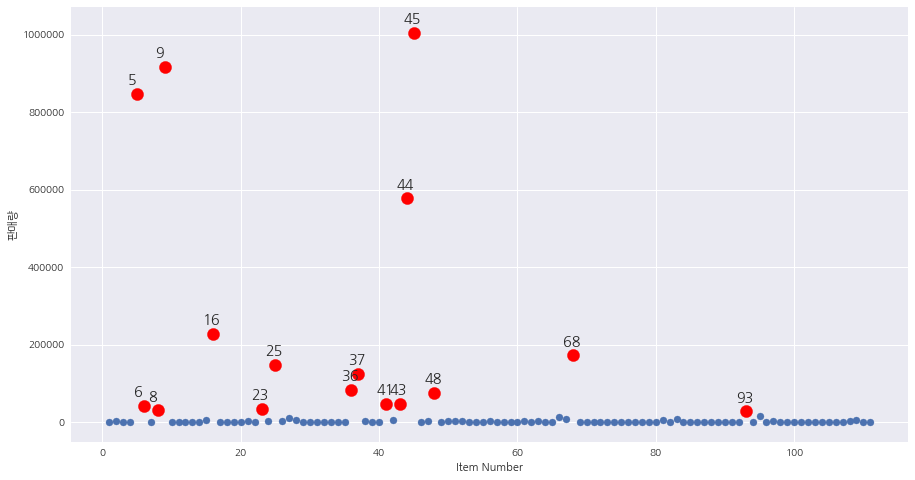

                 0
count      111.000
mean     41054.027
std     161096.077
min         31.000
25%        526.000
50%        781.000
75%       2845.000
max    1005111.000 

Skewness: 4.979809
Kurtosis: 24.816016


In [22]:
df_units_sales_sum = pd.DataFrame(units_sales)
plt.figure(figsize=(15, 8))
plt.xlabel("Item Number")
plt.ylabel("판매량")
plt.scatter(df_unit_sales.units.columns, units_sales)
ax = plt.subplot()
units_idx = np.where(units_sales > 20000)
plt.scatter(df_unit_sales.units.columns[units_idx], units_sales[units_idx], s=150, c="r")
units_nbrs = list(units_idx[0])
utils.annotate_axes(range(len(units_nbrs)), df_unit_sales.units.columns[units_nbrs],\
                    list(zip(df_unit_sales.units.columns[units_nbrs], units_sales[units_nbrs]))\
                    , [(-10, 10)] * len(units_nbrs), size="x-large", ax=ax)
plt.show()

print(round(df_units_sales_sum.describe(), 3),"\n")

print("Skewness: %f" % df_units_sales_sum.skew())
print("Kurtosis: %f" % df_units_sales_sum.kurt())

## 각 아이템별로 판매하는 매장의 수를 나누어서 평균 한 매장에서 아이템별로 팔리는 개수를 비교해보았다.

In [23]:
normalized_units_sales = units_sales/store_nbrs
df_normalized_units_sales = pd.DataFrame(normalized_units_sales)

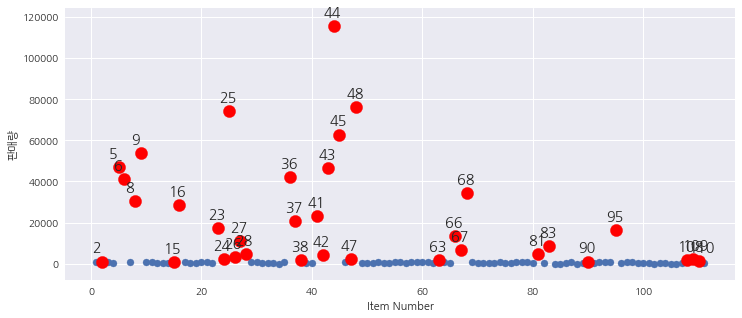

                0
count     111.000
mean     7624.411
std     18555.093
min        31.000
25%       471.900
50%       727.000
75%      1966.500
max    115438.600 

Skewness: 3.409770
Kurtosis: 13.050369


In [24]:
plt.figure(figsize=(12, 5))
plt.scatter(df_unit_sales.units.columns, normalized_units_sales)
plt.xlabel("Item Number")
plt.ylabel("판매량")
ax = plt.subplot()
units_idx = np.where(normalized_units_sales > 1035)
plt.scatter(df_unit_sales.units.columns[units_idx], normalized_units_sales[units_idx], s=150, c="r")
units_nbrs = list(units_idx[0])
utils.annotate_axes(range(len(units_nbrs)), df_unit_sales.units.columns[units_nbrs],\
                    list(zip(df_unit_sales.units.columns[units_nbrs], normalized_units_sales[units_nbrs]))\
                    , [(-10, 10)] * len(units_nbrs), size="x-large", ax=ax)
plt.show()

print(round(df_normalized_units_sales.describe(), 3),"\n")

print("Skewness: %f" % df_normalized_units_sales.skew())
print("Kurtosis: %f" % df_normalized_units_sales.kurt())

## 아이템마다 판매된 유닛수는 일정하지않다.

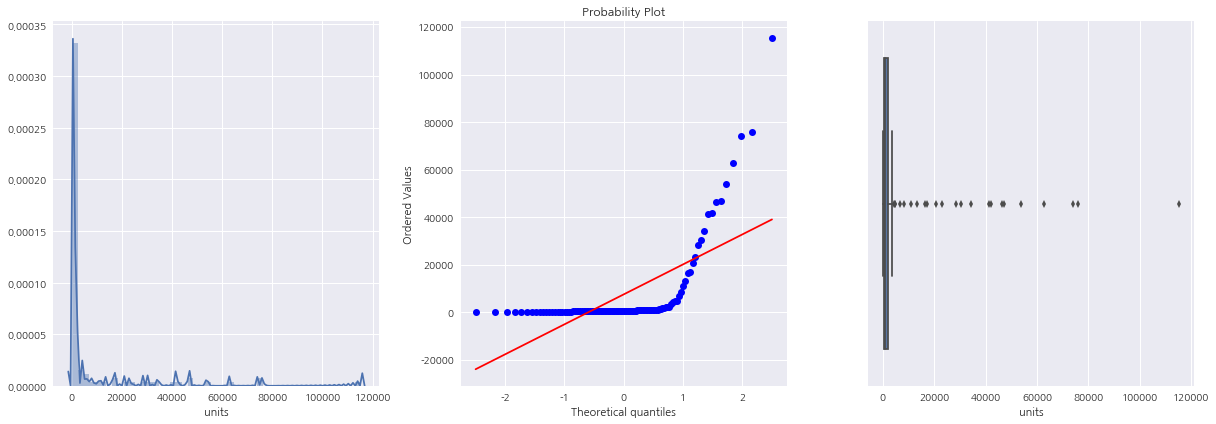

In [25]:
plt.figure(figsize=(17,6))

plt.subplot(131)
plt.xlabel("units")
sns.distplot(normalized_units_sales)

plt.subplot(132)
stats.probplot(normalized_units_sales, plot=plt)

plt.subplot(133)
plt.xlabel("units")
sns.boxplot(normalized_units_sales)
plt.tight_layout()
plt.show()

# 판매되는 유닛수는 정규분포를 따르지 않지만, Log값을 취하면 조금은 다가서는 모습을 볼 수 있다.

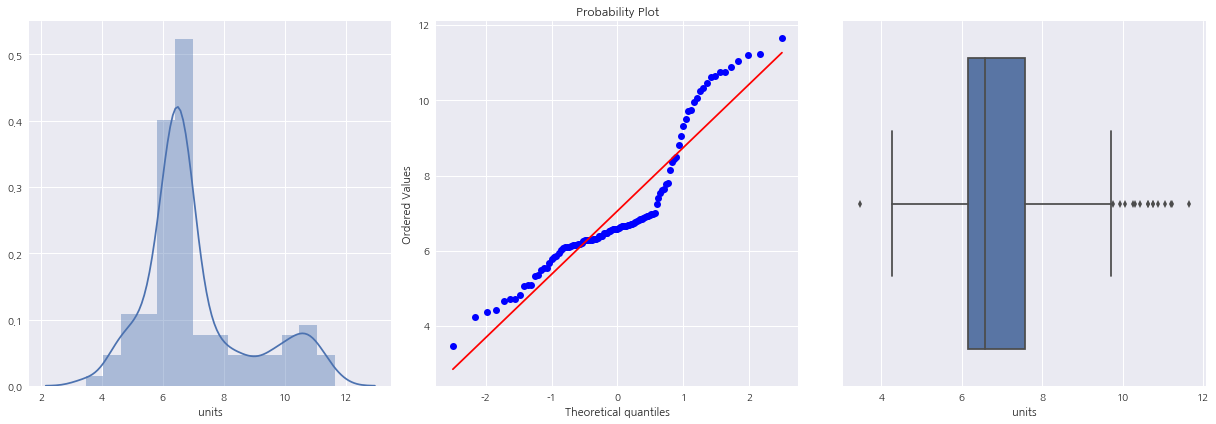

In [26]:
nomalized_SalePrice = np.log1p(normalized_units_sales)

plt.figure(figsize=(17,6))

plt.subplot(131)
plt.xlabel("units")
sns.distplot(nomalized_SalePrice)

plt.subplot(132)
stats.probplot(nomalized_SalePrice, plot=plt)

plt.subplot(133)
plt.xlabel("units")
sns.boxplot(nomalized_SalePrice)
plt.tight_layout()
plt.show()

# Missing Values processing

In [27]:
import awesome_functions as cf

In [94]:
df_weather_ex = df_weather[df_weather['station_nbr']!=5]
cf.isThereNoneData(df_weather_ex)

M Data over 60% : []
T Data over 60% : []
B Data over 60% : []


,Column,Row Count,Missing Data,M Data %,Trace Data,T Data %,Bar Data,B Data %
0,station_nbr,19665,0,0.00,0,0.00,0,0.00
1,date,19665,0,0.00,0,0.00,0,0.00
2,tmax,19665,84,0.43,0,0.00,0,0.00
3,tmin,19665,86,0.44,0,0.00,0,0.00
4,tavg,19665,647,3.29,0,0.00,0,0.00
5,depart,19665,10689,54.36,0,0.00,0,0.00
6,dewpoint,19665,220,1.12,0,0.00,0,0.00
7,wetbulb,19665,400,2.03,0,0.00,0,0.00
8,heat,19665,647,3.29,0,0.00,0,0.00
9,cool,19665,647,3.29,0,0.00,0,0.00


In [71]:
import datetime
from dateutil.parser import parse

In [89]:
def handle_date_Y(a):
    return parse(a).year

def handle_date_M(a):
    return parse(a).month

def handle_date_D(a):
    return parse(a).day

In [95]:
df_weather['year'] = df_weather['date'].apply(handle_date_Y)
df_weather['month'] = df_weather['date'].apply(handle_date_M)
df_weather['day'] = df_weather['date'].apply(handle_date_D)

- Missing Data, '-' Data → NaN Data
- Trace Data  → 0

#### Missing Data 선형으로 처리
1. tmax, tmin : 일 최고기온, 일 최저기온
2. dewpoint: 평균 이슬점
3. preciptotal: 총 강수량
4. stnpressure, sealevel: 특정고도에서 관측된 실제 기압, 해면기압
5. resultspeed, resultdir, avgspeed: 합성풍속, 합성풍향, 평균풍속

In [91]:
df_weather_ex.tail()

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day
20512,16,2014-10-31,53,34,44,M,35,41,21,0,...,M,0.00,29.90,29.99,4.5,03,5.3,2014,10,31
20513,17,2014-10-31,59,34,47,M,32,41,18,0,...,0.0,0.00,29.72,30.39,9.2,01,9.3,2014,10,31
20514,18,2014-10-31,67,49,58,-4,40,50,7,0,...,0.0,0.00,29.78,30.28,10.6,36,11.2,2014,10,31
20515,19,2014-10-31,45,33,39,-6,24,32,26,0,...,0.1,0.02,29.51,30.24,20.4,34,20.9,2014,10,31
20516,20,2014-10-31,68,50,59,M,39,50,6,0,...,0.0,0.00,29.57,30.27,10.5,36,11.2,2014,10,31


In [96]:
df_weather_ex['tmax'] = df_weather_ex['tmax'].apply(cf.changeTypeToInt)
df_weather_ex['tmin'] = df_weather_ex['tmin'].apply(cf.changeTypeToInt)
df_weather_ex['dewpoint'] = df_weather_ex['dewpoint'].apply(cf.changeTypeToInt)
df_weather_ex['preciptotal'] = df_weather_ex['preciptotal'].apply(cf.changeTypeToFloat)
df_weather_ex['stnpressure'] = df_weather_ex['stnpressure'].apply(cf.changeTypeToFloat)
df_weather_ex['sealevel'] = df_weather_ex['sealevel'].apply(cf.changeTypeToFloat)
df_weather_ex['resultspeed'] = df_weather_ex['resultspeed'].apply(cf.changeTypeToFloat)
df_weather_ex['resultdir'] = df_weather_ex['resultdir'].apply(cf.changeTypeToInt)
df_weather_ex['avgspeed'] = df_weather_ex['avgspeed'].apply(cf.changeTypeToFloat)


df_weather_ex['tmax'] = df_weather_ex['tmax'].interpolate()

df_weather_ex['tmin'] = df_weather_ex['tmin'].interpolate()

df_weather_ex['dewpoint'] = df_weather_ex['dewpoint'].interpolate()

df_weather_ex['preciptotal'] = df_weather_ex['preciptotal'].interpolate()

df_weather_ex['stnpressure'] = df_weather_ex['stnpressure'].interpolate()

df_weather_ex['sealevel'] = df_weather_ex['sealevel'].interpolate()
df_weather_ex['sealevel'] = np.where(df_weather_ex['station_nbr'] == 8,'M',df_weather_ex['sealevel'])
df_weather_ex['sealevel'] = df_weather_ex['sealevel'].apply(cf.changeTypeToFloat)

df_weather_ex['resultspeed'] = df_weather_ex['resultspeed'].interpolate()
df_weather_ex['resultdir'] = df_weather_ex['resultdir'].interpolate()
df_weather_ex['avgspeed'] = df_weather_ex['avgspeed'].interpolate()

In [97]:
cf.isThereNoneData(df_weather_ex)

M Data over 60% : []
T Data over 60% : []
B Data over 60% : []


,Column,Row Count,Missing Data,M Data %,Trace Data,T Data %,Bar Data,B Data %
0,station_nbr,19665,0,0.00,0,0.00,0,0.00
1,date,19665,0,0.00,0,0.00,0,0.00
2,tmax,19665,0,0.00,0,0.00,0,0.00
3,tmin,19665,0,0.00,0,0.00,0,0.00
4,tavg,19665,647,3.29,0,0.00,0,0.00
5,depart,19665,10689,54.36,0,0.00,0,0.00
6,dewpoint,19665,0,0.00,0,0.00,0,0.00
7,wetbulb,19665,400,2.03,0,0.00,0,0.00
8,heat,19665,647,3.29,0,0.00,0,0.00
9,cool,19665,647,3.29,0,0.00,0,0.00


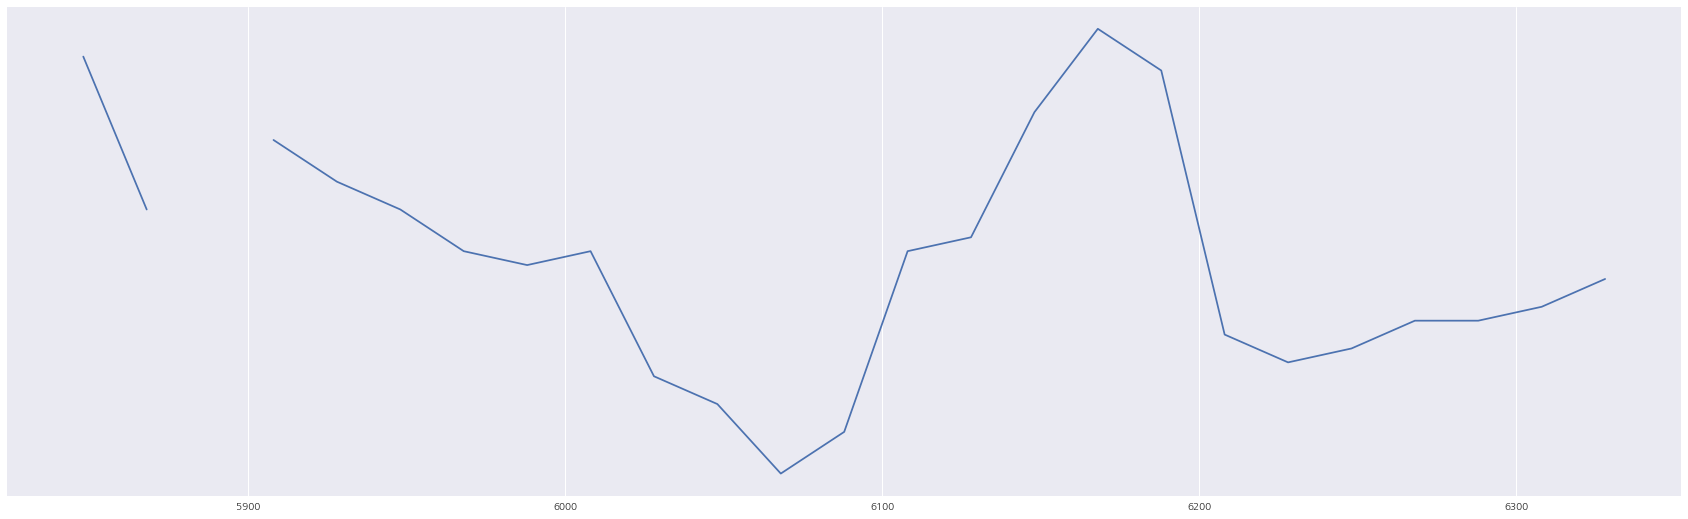

In [58]:
df_weather_ex_station_1 = df_weather_ex[df_weather_ex["station_nbr"]==1]
df_weather_ex_station_1["tmax"] = df_weather_ex_station_1["tmax"].apply(cf.changeTypeToInt)
plt.figure(figsize=(30, 9))
plt.yticks([-10, int(df_weather_ex_station_1["tmax"].max())])
plt.plot(df_weather_ex_station_1[300:325]["tmax"])
plt.show()

In [60]:
df_weather_ex_station_1['tmax'] = df_weather_ex_station_1['tmax'].interpolate()

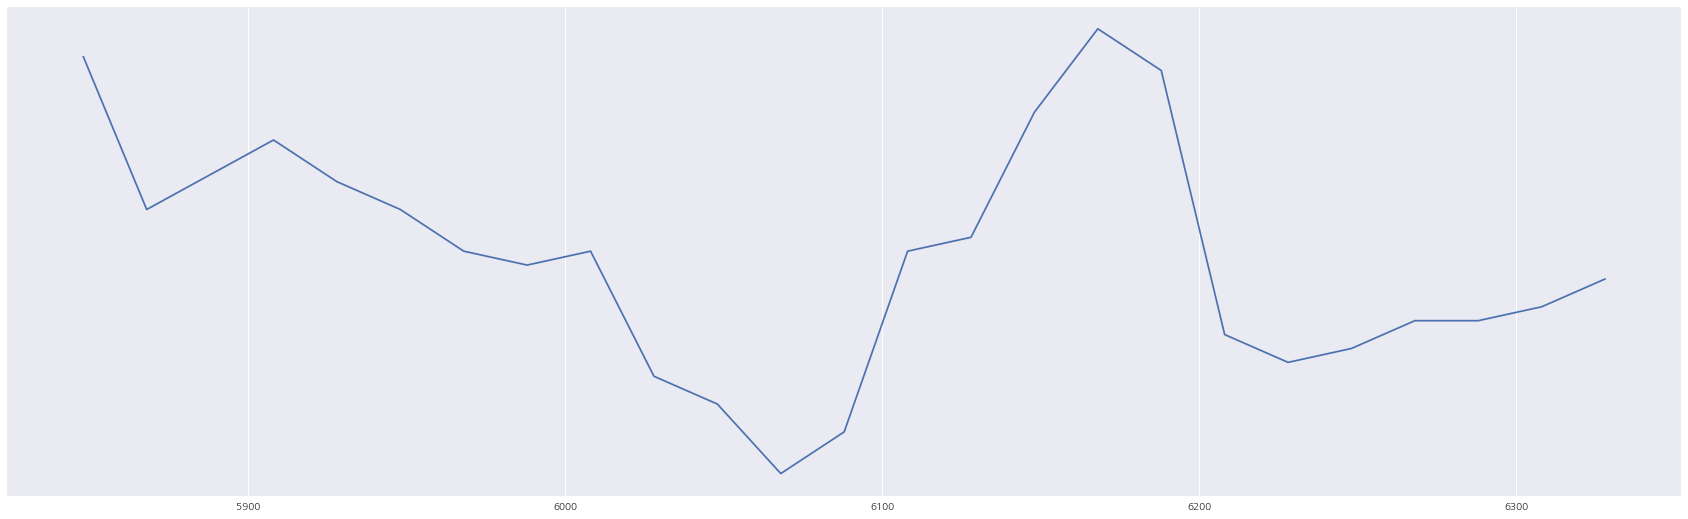

In [61]:
plt.figure(figsize=(30, 9))
plt.yticks([-10, int(df_weather_ex_station_1["tmax"].max())])
plt.plot(df_weather_ex_station_1[300:325]["tmax"])
plt.show()

#### Missing Data 선형처리 外

#### tavg
- Description: 일 평균기온
- Process
    - tmax와 tmin의 평균값으로 Nan Data 채워줌

In [98]:
df_weather_ex['tavg'] = df_weather_ex['tavg'].apply(cf.changeTypeToInt)
df_weather_ex['tavg'] = (df_weather_ex['tmax']+df_weather_ex['tmin'])/2

In [99]:
cf.isThereNoneData(df_weather_ex)

M Data over 60% : []
T Data over 60% : []
B Data over 60% : []


,Column,Row Count,Missing Data,M Data %,Trace Data,T Data %,Bar Data,B Data %
0,station_nbr,19665,0,0.00,0,0.00,0,0.00
1,date,19665,0,0.00,0,0.00,0,0.00
2,tmax,19665,0,0.00,0,0.00,0,0.00
3,tmin,19665,0,0.00,0,0.00,0,0.00
4,tavg,19665,0,0.00,0,0.00,0,0.00
5,depart,19665,10689,54.36,0,0.00,0,0.00
6,dewpoint,19665,0,0.00,0,0.00,0,0.00
7,wetbulb,19665,400,2.03,0,0.00,0,0.00
8,heat,19665,647,3.29,0,0.00,0,0.00
9,cool,19665,647,3.29,0,0.00,0,0.00


#### depart
- Description: 일 평균기온에서 같은 날짜의 30년 평균기온을 뺀 값
- Process
    - 1) 30년 평균을 해당 월의 3년 평균기온으로 대체
    - 2) `일 평균기온에서 각 스테이션별 해당 월의 3년 평균기온을 뺀 값`으로 채워줌

In [101]:
df_weather_ex['depart'] = df_weather_ex['depart'].apply(cf.changeTypeToInt)

In [102]:
# depart_base 컬럼 생성 -> 각 스테이션의 월마다 tavg의 평균 대입
df_weather_depart_total = pd.DataFrame(columns = ["station_nbr", "date","depart_base"])
for i in range(1,21):
    for j in range(1,13):
        df_weather_depart = df_weather_ex[(df_weather_ex['station_nbr']== i)&(df_weather_ex['month']== j)]
        df_weather_depart['depart_base'] = df_weather_ex[(df_weather_ex['station_nbr']== i)&(df_weather_ex['month']== j)]['tavg'].mean()
        df_weather_depart = df_weather_depart[["station_nbr", "date","depart_base"]]
        df_weather_depart_total = pd.concat([df_weather_depart_total, df_weather_depart])
        
df_weather_depart_total["station_nbr"]=df_weather_depart_total["station_nbr"].astype(int)
df_weather_ex = df_weather_ex.merge(df_weather_depart_total, on=["station_nbr", "date"], how='outer')

In [103]:
# depart값이 있으면 depart값을 넣고 아니면 그날의 tavg값에서 depart_base값을 뻄
df_weather_ex['depart'] = np.where(pd.notnull(df_weather_ex['depart']) == True, df_weather_ex['depart'], df_weather_ex['tavg'] - df_weather_ex['depart_base'])

In [104]:
cf.isThereNoneData(df_weather_ex)

M Data over 60% : []
T Data over 60% : []
B Data over 60% : []


,Column,Row Count,Missing Data,M Data %,Trace Data,T Data %,Bar Data,B Data %
0,station_nbr,19665,0,0.00,0,0.00,0,0.00
1,date,19665,0,0.00,0,0.00,0,0.00
2,tmax,19665,0,0.00,0,0.00,0,0.00
3,tmin,19665,0,0.00,0,0.00,0,0.00
4,tavg,19665,0,0.00,0,0.00,0,0.00
5,depart,19665,0,0.00,0,0.00,0,0.00
6,dewpoint,19665,0,0.00,0,0.00,0,0.00
7,wetbulb,19665,400,2.03,0,0.00,0,0.00
8,heat,19665,647,3.29,0,0.00,0,0.00
9,cool,19665,647,3.29,0,0.00,0,0.00


#### wetbulb
- Description: 평균 습구
- Process
    - 각 스테이션별 해당 월의 평균 wetbulb 값으로 채워줌

In [105]:
# wetbulb값은 연속적으로 missing 데이터가 있는 경우가 많아 interpolate명령어 x
df_weather_wetbulb_total = pd.DataFrame(columns = ["station_nbr", "date","wetbulb"])
for i in range(1,21):
    for j in range(1,13):
        df_weather_wetbulb = df_weather_ex[(df_weather_ex['station_nbr']== i)&(df_weather_ex['month']== j)][["station_nbr", "date","wetbulb"]]
        df_weather_wetbulb = df_weather_wetbulb.fillna(df_weather_wetbulb.mean())
        df_weather_wetbulb_total = pd.concat([df_weather_wetbulb_total, df_weather_wetbulb])

In [106]:
# 각 스테이션별 해당 월의 평균 wetbulb 계산
df_weather_wetbulb_total.rename(columns={"wetbulb":"wetbulb_avg"}, inplace = True)
df_weather_wetbulb_total["station_nbr"]=df_weather_wetbulb_total["station_nbr"].astype(int)
df_weather_ex = df_weather_ex.merge(df_weather_wetbulb_total, on=["station_nbr", "date"], how='outer')

In [107]:
df_weather_ex['wetbulb'] = np.where(pd.notnull(df_weather_ex['wetbulb']) == True, df_weather_ex['wetbulb'], df_weather_ex['wetbulb_avg'])
df_weather_ex['wetbulb'] = df_weather_ex['wetbulb'].apply(cf.changeTypeToInt)
df_weather_ex = df_weather_ex.drop(['wetbulb_avg'],axis=1)
df_weather_ex

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,...,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,year,month,day,depart_base
0,1,2012-01-01,52.0,31.0,41.5,12.102151,36.0,40.0,23,0,...,0.05,29.78,29.92,3.60,20.0,4.6,2012,1,1,29.397849
1,2,2012-01-01,48.0,33.0,40.5,16.000000,37.0,39.0,24,0,...,0.07,28.82,29.91,9.10,23.0,11.3,2012,1,1,25.930108
2,3,2012-01-01,55.0,34.0,44.5,9.000000,24.0,36.0,20,0,...,0.00,29.77,30.47,9.90,31.0,10.0,2012,1,1,40.134409
3,4,2012-01-01,63.0,47.0,55.0,4.000000,28.0,43.0,10,0,...,0.00,29.79,30.48,8.00,35.0,8.2,2012,1,1,53.102151
4,6,2012-01-01,63.0,34.0,48.5,0.000000,31.0,43.0,16,0,...,0.00,29.95,30.47,14.00,36.0,13.8,2012,1,1,49.790323
5,7,2012-01-01,50.0,33.0,41.5,0.887097,26.0,35.0,23,0,...,0.00,29.15,30.54,10.30,32.0,10.2,2012,1,1,40.612903
6,8,2012-01-01,66.0,45.0,55.5,2.212366,34.0,46.0,M,M,...,0.00,30.05,NaN,11.00,36.0,10.9,2012,1,1,53.287634
7,9,2012-01-01,34.0,19.0,26.5,10.473118,17.0,23.0,38,0,...,0.00,29.34,30.09,22.80,30.0,22.5,2012,1,1,16.026882
8,10,2012-01-01,73.0,53.0,63.0,4.881720,55.0,58.0,2,0,...,0.00,30.16,30.19,5.10,24.0,5.5,2012,1,1,58.118280
9,11,2012-01-01,72.0,48.0,60.0,7.000000,54.0,56.0,5,0,...,0.00,30.15,30.18,4.60,23.0,4.8,2012,1,1,54.903226


In [108]:
cf.isThereNoneData(df_weather_ex)

M Data over 60% : []
T Data over 60% : []
B Data over 60% : []


,Column,Row Count,Missing Data,M Data %,Trace Data,T Data %,Bar Data,B Data %
0,station_nbr,19665,0,0.00,0,0.00,0,0.00
1,date,19665,0,0.00,0,0.00,0,0.00
2,tmax,19665,0,0.00,0,0.00,0,0.00
3,tmin,19665,0,0.00,0,0.00,0,0.00
4,tavg,19665,0,0.00,0,0.00,0,0.00
5,depart,19665,0,0.00,0,0.00,0,0.00
6,dewpoint,19665,0,0.00,0,0.00,0,0.00
7,wetbulb,19665,0,0.00,0,0.00,0,0.00
8,heat,19665,647,3.29,0,0.00,0,0.00
9,cool,19665,647,3.29,0,0.00,0,0.00


#### heat, cool
- Description: 건물이 화씨 65도를 유지하기 위해 필요한 난방/냉방 게이지
- Process
    - heat: 화씨 65에서 일 평균기온을 뺀 값
    - cool: 일 평균기온에서 화씨 65도를 뺀 값(0이하일 경우 0으로 처리)

In [109]:
df_weather_ex['tavg'] = df_weather_ex['tavg'].apply(cf.changeTypeToInt)
df_weather_ex['heat'] = df_weather_ex['heat'].apply(cf.changeTypeToInt)
df_weather_ex['cool'] = df_weather_ex['cool'].apply(cf.changeTypeToInt)

In [110]:
print(pd.isnull(df_weather_ex['heat']).sum())
print(pd.isnull(df_weather_ex['cool']).sum())

647
647


In [111]:
df_weather_ex['heat'] = 65-df_weather_ex['tavg']
df_weather_ex['cool'] = df_weather_ex['tavg']-65
df_weather_ex['cool'] = np.where(df_weather_ex['cool'] < 0, 0,df_weather_ex['cool'])

In [112]:
print(pd.isnull(df_weather_ex['heat']).sum())
print(pd.isnull(df_weather_ex['cool']).sum())

0
0


In [117]:
cf.isThereNoneData(df_weather_ex)

M Data over 60% : []
T Data over 60% : []
B Data over 60% : []


,Column,Row Count,Missing Data,M Data %,Trace Data,T Data %,Bar Data,B Data %
0,station_nbr,19665,0,0.00,0,0.00,0,0.0
1,date,19665,0,0.00,0,0.00,0,0.0
2,tmax,19665,0,0.00,0,0.00,0,0.0
3,tmin,19665,0,0.00,0,0.00,0,0.0
4,tavg,19665,0,0.00,0,0.00,0,0.0
5,depart,19665,0,0.00,0,0.00,0,0.0
6,dewpoint,19665,0,0.00,0,0.00,0,0.0
7,wetbulb,19665,0,0.00,0,0.00,0,0.0
8,heat,19665,0,0.00,0,0.00,0,0.0
9,cool,19665,0,0.00,0,0.00,0,0.0


#### Missing Data 열삭제

#### sunrise, sunset
- Description: 일출시간, 일몰시간
- Process: 데이터 전체가 없는 기상관측소가 20개중 9개이므로 채울 수 없음(열 삭제)

In [113]:
df_weather_ex["sunrise"] = df_weather_ex["sunrise"].apply(cf.changeTypeToInt)
df_weather_ex["sunset"] = df_weather_ex["sunset"].apply(cf.changeTypeToInt)

In [114]:
def isnan(a):
    if np.isnan(a):
        return 0
    else:
        return 1

In [123]:
df_weather_sunrise_count = df_weather_ex.copy()
df_weather_sunrise_count["sunrise_count"] = df_weather_ex["sunrise"].apply(isnan)
df_weather_sunrise_count["sunset_count"] = df_weather_ex["sunset"].apply(isnan)

In [124]:
df_weather_sunrise_count.pivot_table(["sunrise_count", "sunset_count"], ["station_nbr"], aggfunc=np.sum)

,sunrise_count,sunset_count
station_nbr,,
1,0,0
2,1004,1004
3,1004,1004
4,1004,1004
6,1004,1004
7,0,0
8,0,0
9,0,0
10,1004,1004


#### snowfall
- Description: 강설량
- Process: 데이터 전체가 없는 기상관측소가 20개중 6개이므로 채울 수 없음(열 삭제)

In [126]:
df_weather_snowfall_count = df_weather_ex.copy()
df_weather_snowfall_count["snowfall"] = df_weather_ex["snowfall"].apply(cf.changeTypeToFloat)
df_weather_snowfall_count["snowfall_count"] = df_weather_ex["snowfall"].apply(isnan)
df_weather_snowfall_count.pivot_table(["snowfall_count"], ["station_nbr"], aggfunc=np.sum)

,snowfall_count
station_nbr,
1,0
2,1024
3,1031
4,1030
6,1026
7,978
8,5
9,18
10,0
